
# Сегментация изображений

---


Cкачаем и разархивируем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>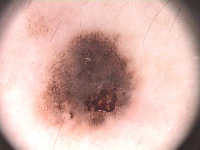</td><td>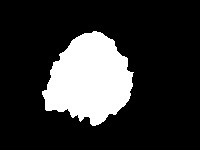</td></tr></table>

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем сегментировать их.

In [1]:
#! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

In [2]:
#get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Для загрузки датасета я предлагаю использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' 

In [3]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Изменим их размер на $256\times256 $ пикселей. [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) можно использовать для изменения размера изображений. 
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [4]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [5]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [6]:
len(lesions)

200

Чтобы убедиться, что все корректно, нарисуем несколько изображений

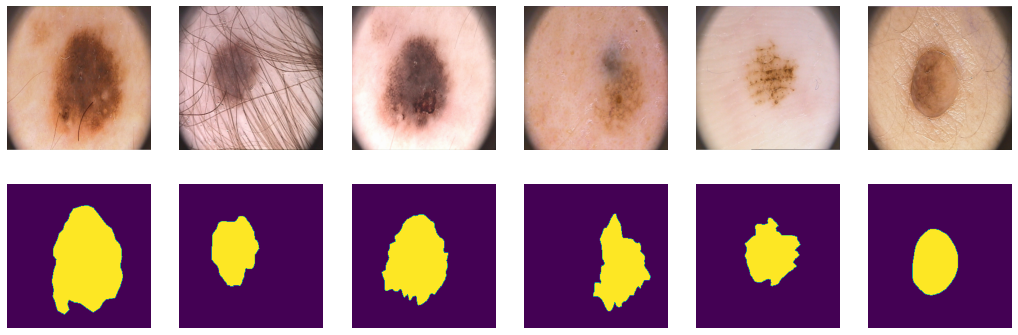

In [7]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

In [8]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from time import time
import seaborn as sns
import pickle
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 6)

Разделим наши 200 картинок на 100/50/50
 для валидации и теста

In [9]:
# зафиксируем Random Seed, чтобы при перезапуске ноутбука разбиение на train/valid/test было одним и тем же
np.random.seed(42)
torch.manual_seed(42)
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [10]:
batch_size = 5
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

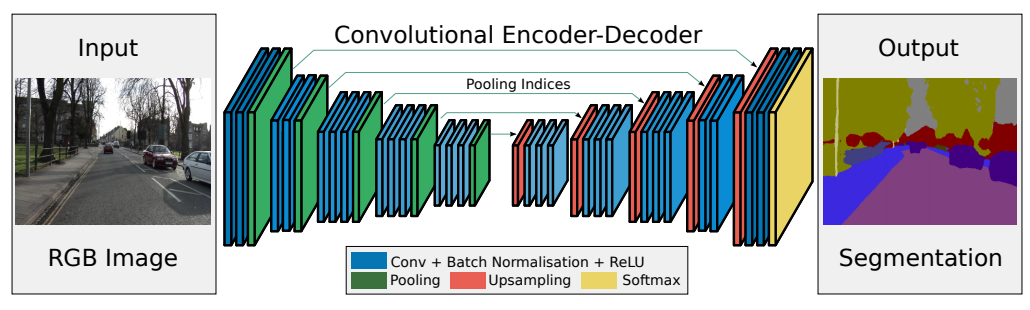

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [10]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(1024),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=1),
            nn.BatchNorm2d(1024),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),            
            nn.ReLU()
        )
        
        # decoder (upsampling)
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)

        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1),
        )
        
    def forward(self, x):
        # encoder
        x, i0 = self.pool(self.enc_conv0(x))
        x, i1 = self.pool(self.enc_conv1(x))
        x, i2 = self.pool(self.enc_conv2(x))
        x, i3 = self.pool(self.enc_conv3(x))

        # bottleneck
        x = self.bottleneck_conv(x)

        # decoder
        x = self.dec_conv0(self.unpool(x, i3))
        x = self.dec_conv1(self.unpool(x, i2))
        x = self.dec_conv2(self.unpool(x, i1))
        x = self.dec_conv3(self.unpool(x, i0))        

        return x

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


To clarify this we can see on the segmentation:
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


And the intersection will be the following:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [11]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## Функция потерь [1 балл]

Теперь не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) в Тарая функция эквивалентна и не так подвержена численной неустойчивости.

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [12]:
def bce_loss(y_real, y_pred):
    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)

    return torch.mean(
        torch.max(y_pred, torch.zeros_like(y_pred)) 
        - y_real * y_pred + torch.log(1 + torch.exp(-torch.abs(y_pred))))

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [13]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, sheduler=None, pictures=True):
    val_scores = []
    train_scores = []
    train_losses = []
    val_losses = []
    times = []

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            Y_pred = model.forward(X_batch) # forward
            loss =  loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights
            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
            
        toc = time()
        if not pictures:
            clear_output(wait=True)            
            
        print('loss: %f' % avg_loss)
        # testing mode
        avg_loss_val = 0
        model.eval()
        for X_val, Y_val in data_val:
            Y_pred = model(X_val.to(device)).detach().cpu()
            loss_val = loss_fn(Y_val, Y_pred)
            avg_loss_val += loss_val / len(data_val)
           
        # collect score, time ans loss
        val_scores.append(score_model(model, iou_pytorch, data_val))
        train_scores.append(score_model(model, iou_pytorch, data_tr))
        train_losses.append(float(avg_loss.detach().cpu().numpy()))
        val_losses.append(float(avg_loss_val.detach().cpu().numpy()))
        times.append(toc-tic)
        
        # Visualize tools
        
        if pictures:
            clear_output(wait=True)
            plt.figure(figsize=(24, 12))
            for k in range(5):
                plt.subplot(3, 5, k+1)
                plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
                plt.title('Real')
                plt.axis('off')

                plt.subplot(3, 5, k+6)
                plt.imshow(Y_pred[k, 0] > 0.5, cmap='gray')
                plt.title('Output')
                plt.axis('off')

                plt.subplot(3, 5, k+11)
                plt.imshow(Y_val[k, 0], cmap='gray')
                plt.title('target')
                plt.axis('off')
    
            plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
            plt.show()
        if sheduler:
            sheduler.step(metrics=avg_loss)
            
    hist = {'val_scores': val_scores, 
            'val_losses': val_losses, 
            'train_scores': train_scores,
            'train_losses': train_losses,
            'times': times}
    
    return hist

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [14]:
# принимает на вход модель, ф-ю потерь и DataLoader, возвращает среднюю ошибку за эпоху
def val_epoch(model, loss_fn, data_val):
    avg_loss_val = 0
    model.eval()
    for X_val, Y_val in data_val:
        Y_pred = model(X_val.to(device)).detach().cpu()
        loss_val = loss_fn(Y_val, Y_pred)
        avg_loss_val += loss_val / len(data_val)
    return avg_loss_val

In [15]:
# predict + score
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        X_batch = X_batch.to(device)
        Y_pred = torch.sigmoid(model(X_batch))
        scores += metric(Y_pred>0.5, Y_label.to(device)).mean().item()

    return scores/len(data)

In [16]:
def plot_one_picture(model, path):
    """Ф-я принимает на вход модель и путь к фотографии, строит маску и печатает изображения""" 
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    x = np.moveaxis(resize(imread(path), (256, 256), mode='constant', anti_aliasing=True), 2, 0)
    y = torch.Tensor(x).unsqueeze(0)
    model.eval()
    y_pred = model(y.to(device)).detach().cpu()
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(np.moveaxis(x, 0, -1), cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(y_pred[0, 0].cpu() > 0.5, cmap='gray')

In [17]:
# вспомогательная функция для отрисовки графиков обучения
def history_plot(data, name):
    plt.subplot(1, 2, 1)
    sns.lineplot(data=data['train_scores'], label='train_scores').set(
    xlabel='epoches', ylabel='score', title=name);
    sns.lineplot(data=data['val_scores'], label='val_scores').set(
    xlabel='epoches', ylabel='score', title=name);
    plt.legend()
    plt.subplot(1, 2, 2)
    sns.lineplot(data=data['train_losses'], label='train_losses').set(
    xlabel='epoches', ylabel='loss', title=name);
    sns.lineplot(data=data['val_losses'], label='val_losses').set(
    xlabel='epoches', ylabel='loss', title=name);
    plt.legend();

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [23]:
model = SegNet().to(device)

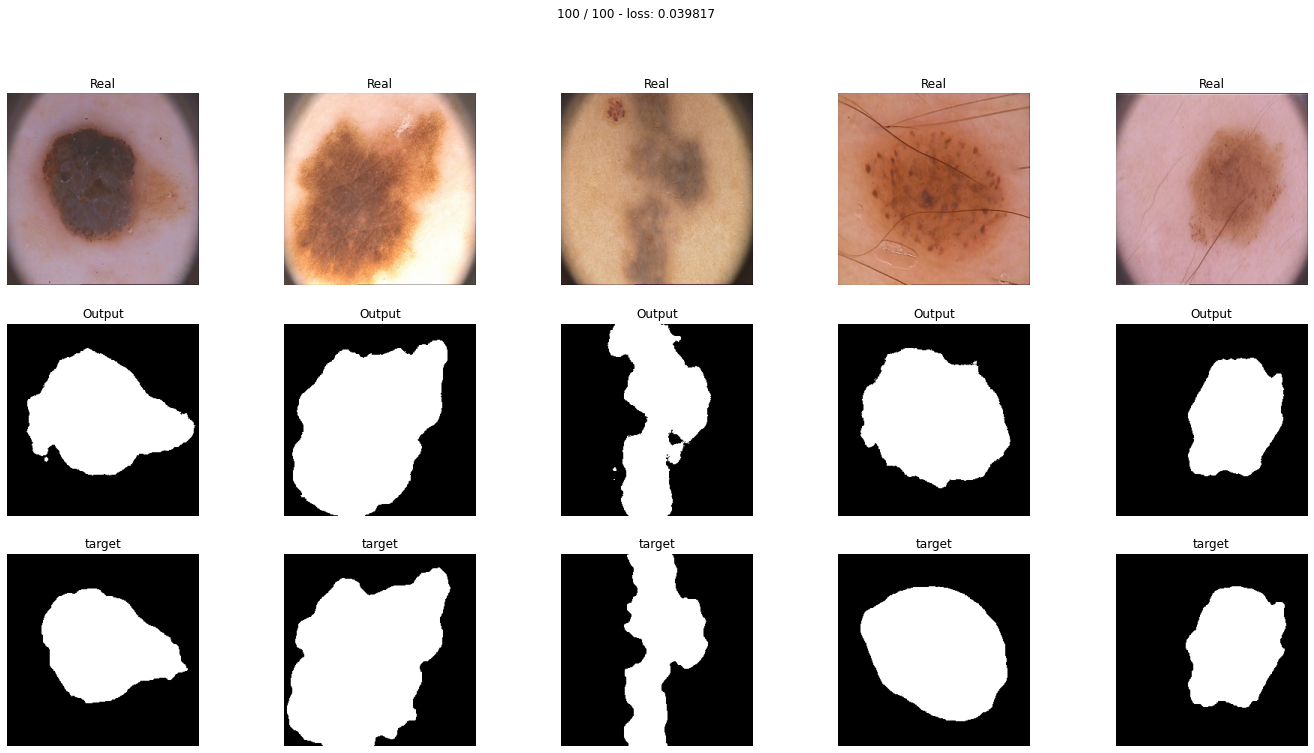

In [24]:
c = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
shed = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5,  factor=0.5)
segnet_bce = train(model, optimizer, bce_loss, max_epochs, data_tr, data_val, shed, pictures=True)

In [25]:
score_model(model, iou_pytorch, data_val)

0.8140000164508819

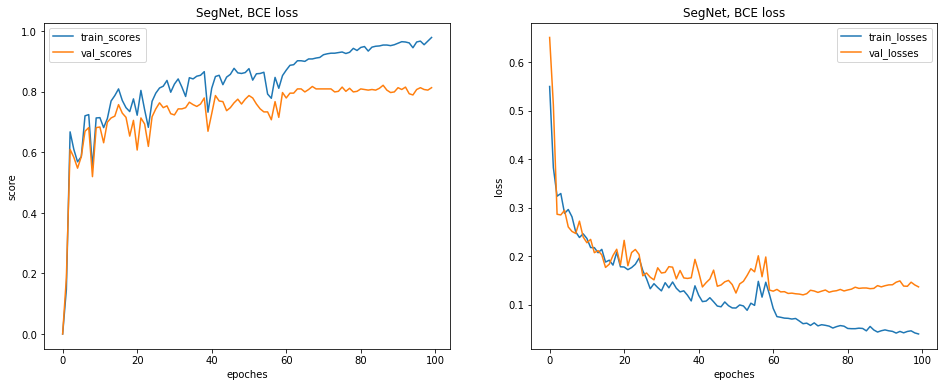

In [26]:
history_plot(segnet_bce, 'SegNet, BCE loss')

In [27]:
# сохраняем модель и историю обучения для отчета
torch.save(model.state_dict(), "./segnet_bce.pth")
with open('segnet_bce.pkl', 'wb') as f:
    pickle.dump(segnet_bce, f)

In [20]:
#model.load_state_dict(torch.load("./bce_loss_100epochs.pth"))

<All keys matched successfully>

Ответьте себе на вопрос: не переобучается ли моя модель?

Да, модель начинает переобучаться после примерно 50-й эпохи.

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало, прежде чем бить тревогу попробуйте поперебирать различные варианты, убедитесь, что во всех других сетапах сетть достигает желанного результата. СПОЙЛЕР: учиться она будеет при всех лоссах предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникаемой в математической формуле.


In [18]:
def dice_loss(y_real, y_pred):
    y_pred = torch.sigmoid(y_pred)
    y_pred = y_pred.contiguous().view(y_pred.shape[0], -1)
    y_real = y_real.contiguous().view(y_real.shape[0], -1)
    eps = 1e-7
    num = 2 * torch.sum(torch.mul(y_pred, y_real), dim=1) + eps
    den = torch.sum(y_pred + y_real, dim=1) + eps
    res = 1 - num / den
    return res.mean()

In [22]:
model_dice = SegNet().to(device)

Проводим тестирование:

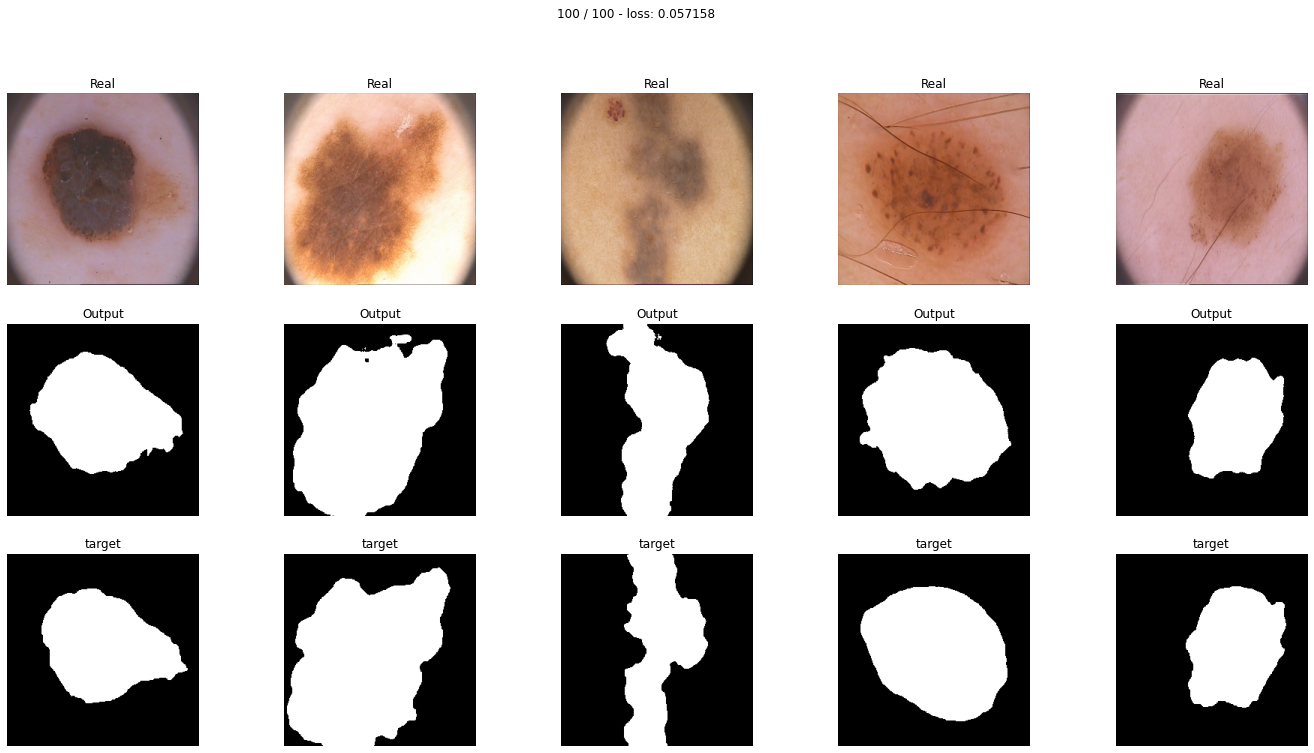

In [23]:
max_epochs = 100
optimizer = optim.Adam(model_dice.parameters(), lr=0.0001)
shed = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5,  factor=0.5)
segnet_dice = train(model_dice, optimizer, dice_loss, max_epochs, data_tr, data_val, shed)

In [24]:
score_model(model_dice, iou_pytorch, data_val)

0.8080000400543212

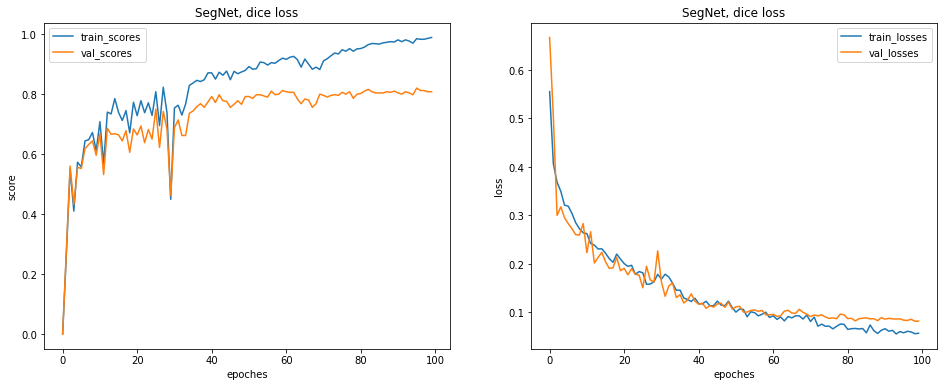

In [25]:
history_plot(segnet_dice, 'SegNet, dice loss')

In [26]:
# сохраняем можель и историю обучения для отчета
torch.save(model_dice.state_dict(), "./segnet_dice.pth")
with open('segnet_dice.pkl', 'wb') as f:
    pickle.dump(segnet_dice, f)

In [ ]:
#model.load_state_dict(torch.load("./dice_loss_100epochs.pth"))

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [28]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred =  torch.clamp(y_pred, eps, 1)
    bce = bce_loss(y_real, y_pred)
    res = (1 - torch.exp(-bce)) ** gamma * bce
    return res.mean()

In [59]:
model_focal = SegNet().to(device)

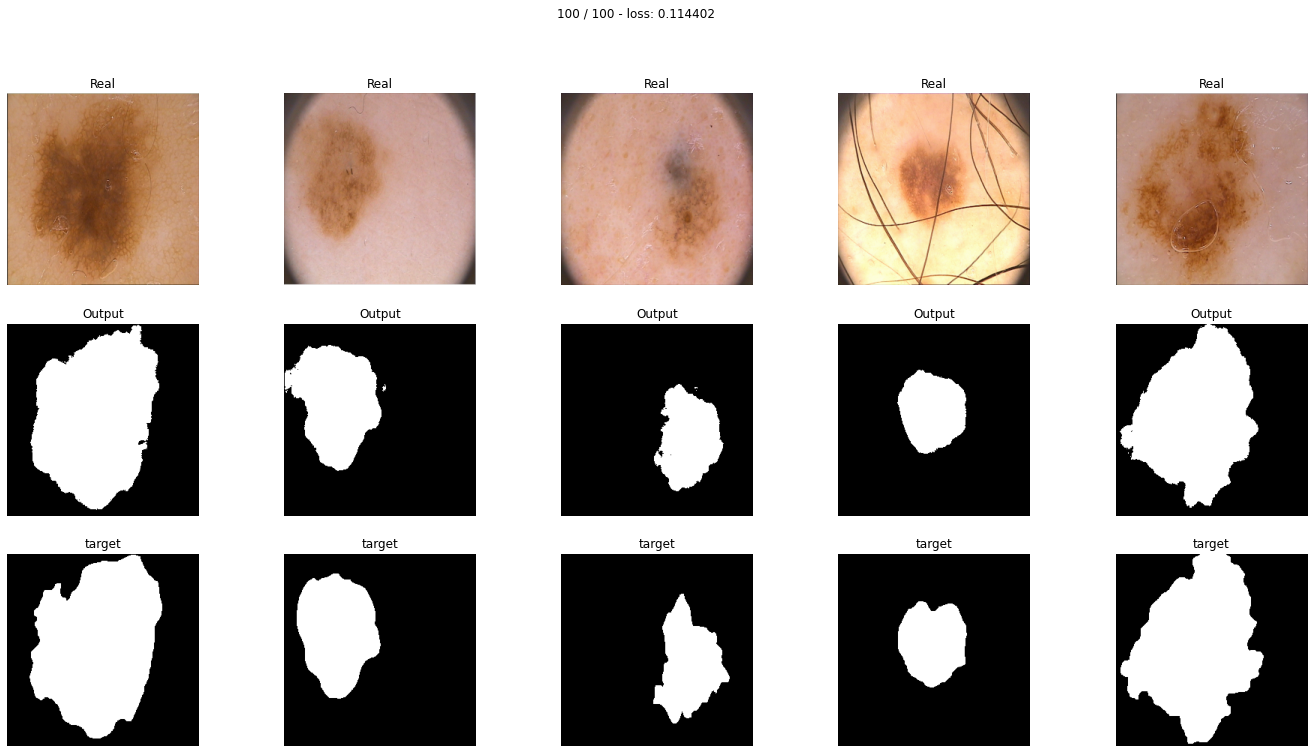

In [60]:
max_epochs = 100
optimizer = optim.Adam(model_focal.parameters(), lr=0.0001)
shed = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5,  factor=0.5)
segnet_focal = train(model_focal, optimizer, focal_loss, max_epochs, data_tr, data_val, shed)

In [61]:
score_model(model_focal, iou_pytorch, data_val)

0.7980000257492066

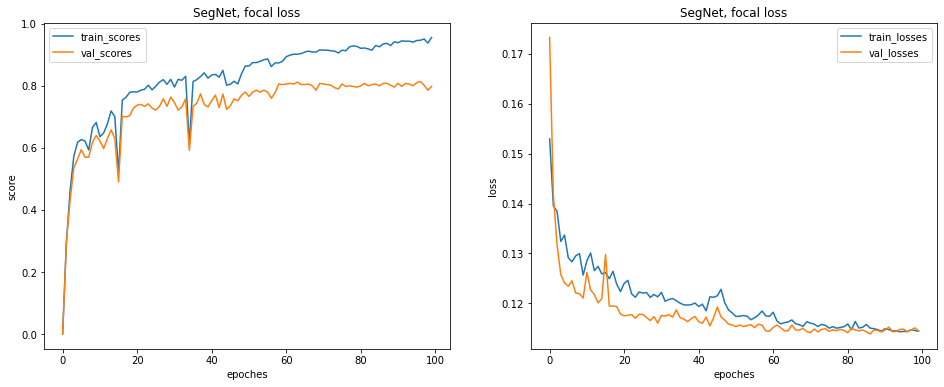

In [62]:
history_plot(segnet_focal, 'SegNet, focal loss')

In [63]:
# сохраняем модель и историю обучения для отчета
torch.save(model_focal.state_dict(), "./segnet_focal.pth")
with open('segnet_focal.pkl', 'wb') as f:
    pickle.dump(segnet_focal, f)

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме того, провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

Попробуем реализовать Lovasz-hinge loss, версия lovasz loss для случая бинарной сегментации, которая по сути является некоторой "надстройкой" над Jaccard loss. Вот несколько выдержек из статьи:

Our approach is based on the recent development of general strategies for generating convex surrogates to submodular loss functions, including the Lovasz hinge. Based on the result that the Jaccard loss is submodular, this strategy is directly applicable. 

We apply the Lovasz hinge with
Jaccard loss to the problem of binary image segmentation. 

In order to optimize the Jaccard index in a continuous
optimization framework, we consider smooth extensions of
this discrete loss. The extensions are based on submodular analysis of set functions, where the set function maps
from a set of mispredictions to the set of real numbers

For a segmentation output y˜ and ground truth y∗, we define the set of mispredicted pixels for class c as

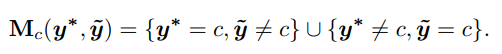

For a fixed ground truth y∗, the Jaccard loss in Eq. can be rewritten as a function of the set of mispredictions

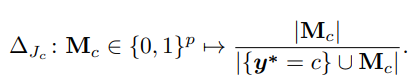

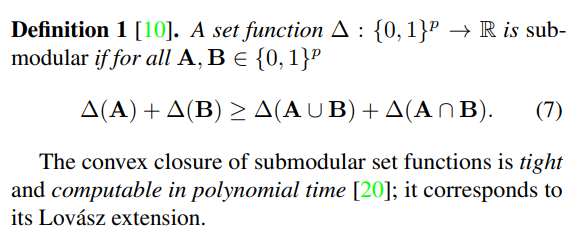
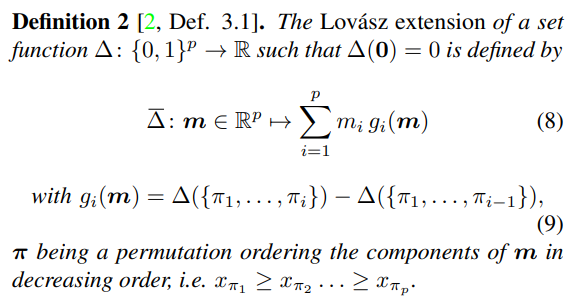

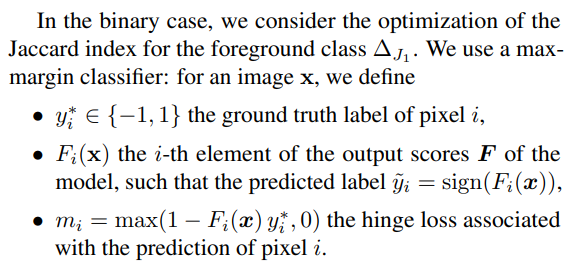

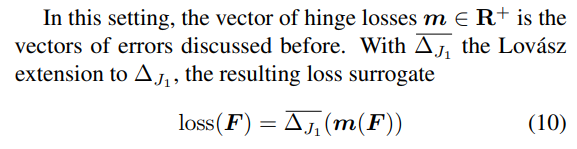

In [29]:
def lovasz_loss(y_real, y_pred):
    y_real = y_real.view(-1)
    y_pred = y_pred.view(-1)
    
    signs = 2. * y_real.float() - 1.
    errors = (1. - y_pred * signs)
    errors_sorted, ind = torch.sort(errors, dim=0, descending=True)
    gt_sorted = y_real[ind.data]
    
    inter = gt_sorted.sum() - gt_sorted.float().cumsum(0)
    union = gt_sorted.sum() + (1 - gt_sorted).float().cumsum(0)
    
    jaccard = 1. - inter / union
    jaccard[1:len(gt_sorted)] = jaccard[1:len(gt_sorted)] - jaccard[0:-1]

    loss = torch.dot(F.relu(errors_sorted), jaccard)
    return loss

In [21]:
model_lovasz = SegNet().to(device)

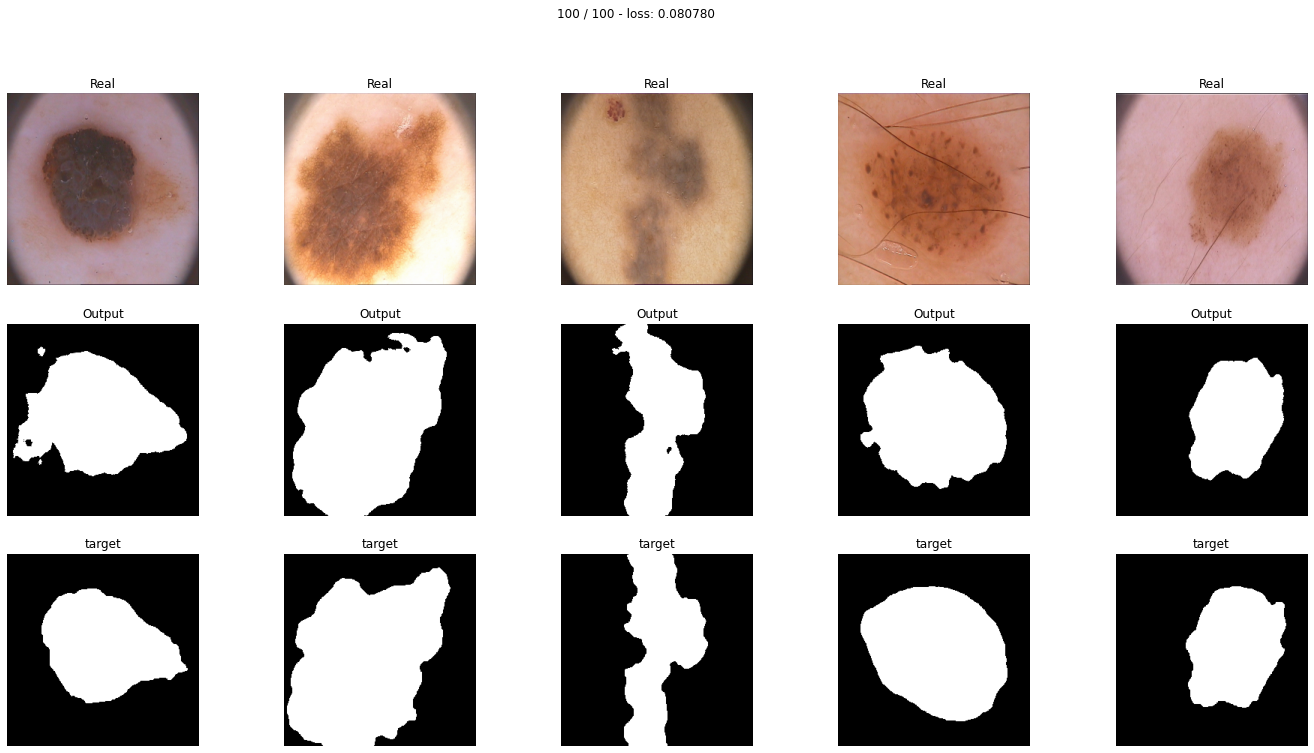

In [22]:
max_epochs = 100
optimizer = optim.Adam(model_lovasz.parameters(), lr=0.0001)
shed = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5,  factor=0.5)
segnet_lovasz = train(model_lovasz, optimizer, lovasz_loss, max_epochs, data_tr, data_val, shed)

In [23]:
score_model(model_lovasz, iou_pytorch, data_val)

0.8120000422000885

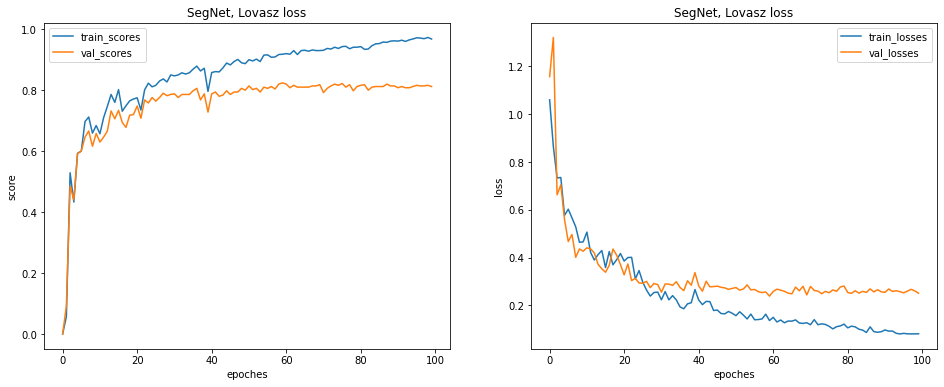

In [24]:
history_plot(segnet_lovasz, 'SegNet, Lovasz loss')

Score +- как и при обучении с прошлыми лоссами при том, что val_loss сходится хуже.

In [25]:
# сохраняем модель и историю обучения для отчета
torch.save(model_lovasz.state_dict(), "./segnet_lovasz.pth")
with open('segnet_lovasz.pkl', 'wb') as f:
    pickle.dump(segnet_lovasz, f)

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Учитывая медицинское изображение, он выводит изображение в оттенках серого, представляющее вероятность того, что каждый пиксель является интересующей областью.

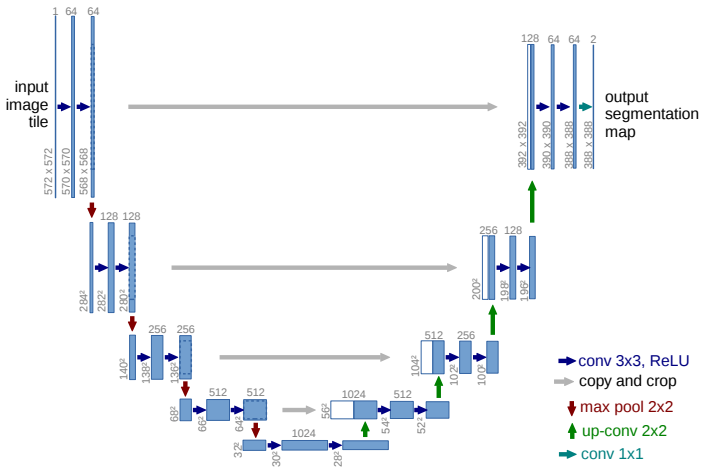

У нас в архитектуре все так же существует енкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются skip-conenctions. Элементы соединяющие части декодера и енкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [19]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(1024),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=1),
            nn.BatchNorm2d(1024),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),            
            nn.ReLU()
        )
        
        # decoder (upsampling)
        self.unpool = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)         
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x) # 3 -> 64       
        e1 = self.enc_conv1(self.pool(e0)) # 64 -> 128
        e2 = self.enc_conv2(self.pool(e1)) # 128 -> 256
        e3 = self.enc_conv3(self.pool(e2)) # 256 -> 512

        # bottleneck
        b = self.unpool(self.bottleneck_conv(self.pool(e3))) # 512 -> 1024 -> 512

        # decoder
        d0 = torch.cat((b, e3), dim=1)
        d0 = self.unpool(self.dec_conv0(d0))
        d1 = torch.cat((d0, e2), dim=1)
        d1 = self.unpool(self.dec_conv1(d1))
        d2 = torch.cat((d1, e1), dim=1)
        d2 = self.unpool(self.dec_conv2(d2))
        d3 = torch.cat((d2, e0), dim=1)
        d3 = self.dec_conv3(d3)

        return d3

In [27]:
unet_model = UNet().to(device)

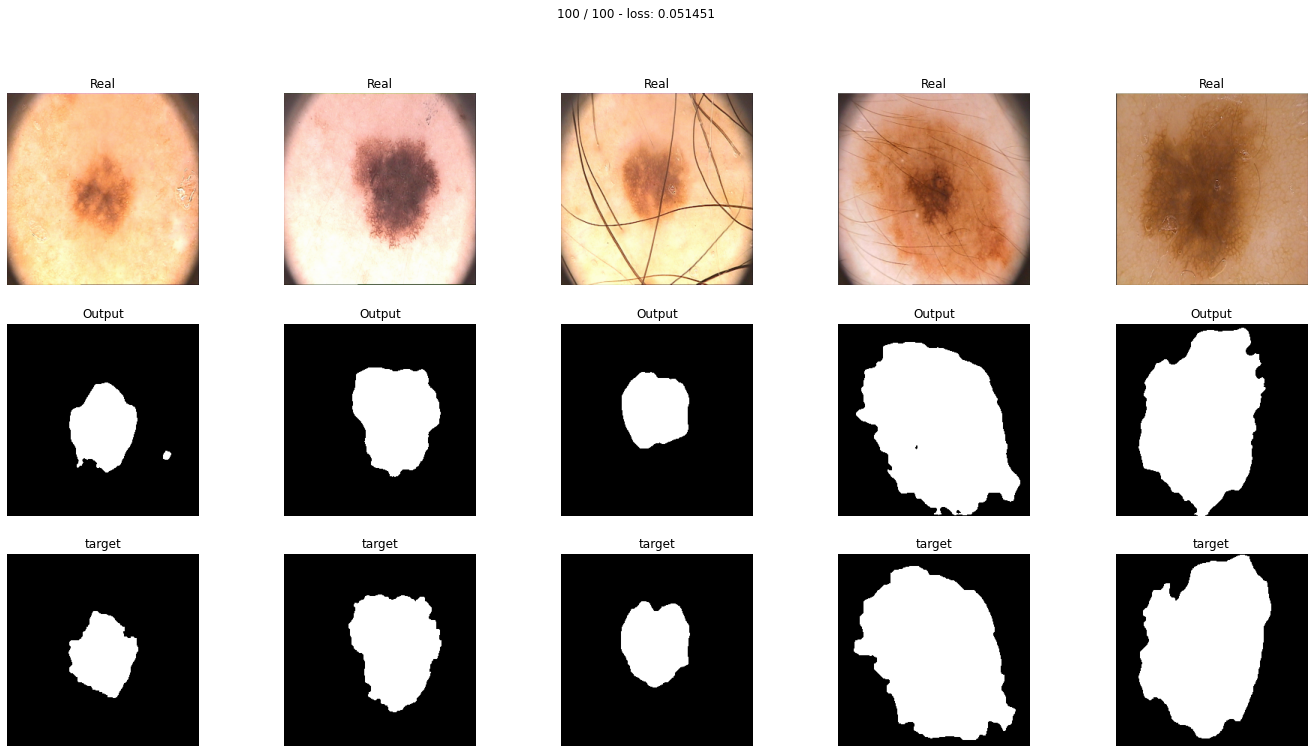

In [28]:
max_epochs = 100
optimizer = optim.Adam(unet_model.parameters(), lr=0.0001)
shed = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5,  factor=0.5)
unet_bce = train(unet_model, optimizer, bce_loss, max_epochs, data_tr, data_val, shed, pictures=True)

In [37]:
score_model(unet_model, iou_pytorch, data_val)

0.8060000240802765

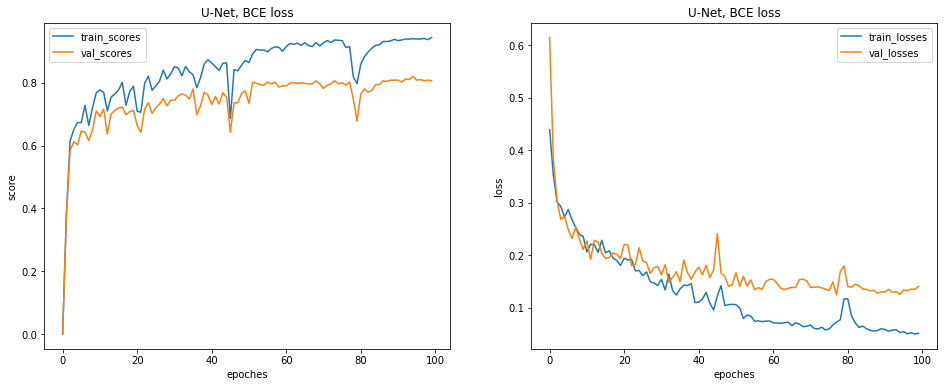

In [30]:
history_plot(unet_bce, 'U-Net, BCE loss')

In [31]:
# сохраняем модель и историю обучения для отчета
torch.save(unet_model.state_dict(), "./unet_bce.pth")
with open('unet_bce.pkl', 'wb') as f:
    pickle.dump(unet_bce, f)

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [20]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        self.pool0 = nn.Conv2d(64, 64, kernel_size=2, stride=2)
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.pool1 = nn.Conv2d(128, 128, kernel_size=2, stride=2)

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
        self.pool2 = nn.Conv2d(256, 256, kernel_size=2, stride=2)
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        
        self.pool3 = nn.Conv2d(512, 512, kernel_size=2, stride=2)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(1024),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=1),
            nn.BatchNorm2d(1024),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),            
            nn.ReLU()
        )
        
        # decoder (upsampling)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256)
        )
        self.unpool0 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)
        
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.unpool1= nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2)
        
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.unpool2= nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)
        
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)       
        )

        self.unpool3 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
            
    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x) # 3 -> 64       
        e1 = self.enc_conv1(self.pool0(e0)) # 64 -> 128
        e2 = self.enc_conv2(self.pool1(e1)) # 128 -> 256
        e3 = self.enc_conv3(self.pool2(e2)) # 256 -> 512

        # bottleneck
        b = self.unpool0(self.bottleneck_conv(self.pool3(e3))) # 512 -> 1024 -> 512

        # decoder
        d0 = torch.cat((b, e3), dim=1)
        d0 = self.unpool1(self.dec_conv0(d0))
        d1 = torch.cat((d0, e2), dim=1)
        d1 = self.unpool2(self.dec_conv1(d1))
        d2 = torch.cat((d1, e1), dim=1)
        d2 = self.unpool3(self.dec_conv2(d2))
        d3 = torch.cat((d2, e0), dim=1)
        d3 = self.dec_conv3(d3)

        return d3

In [33]:
unet2_model = UNet2().to(device)

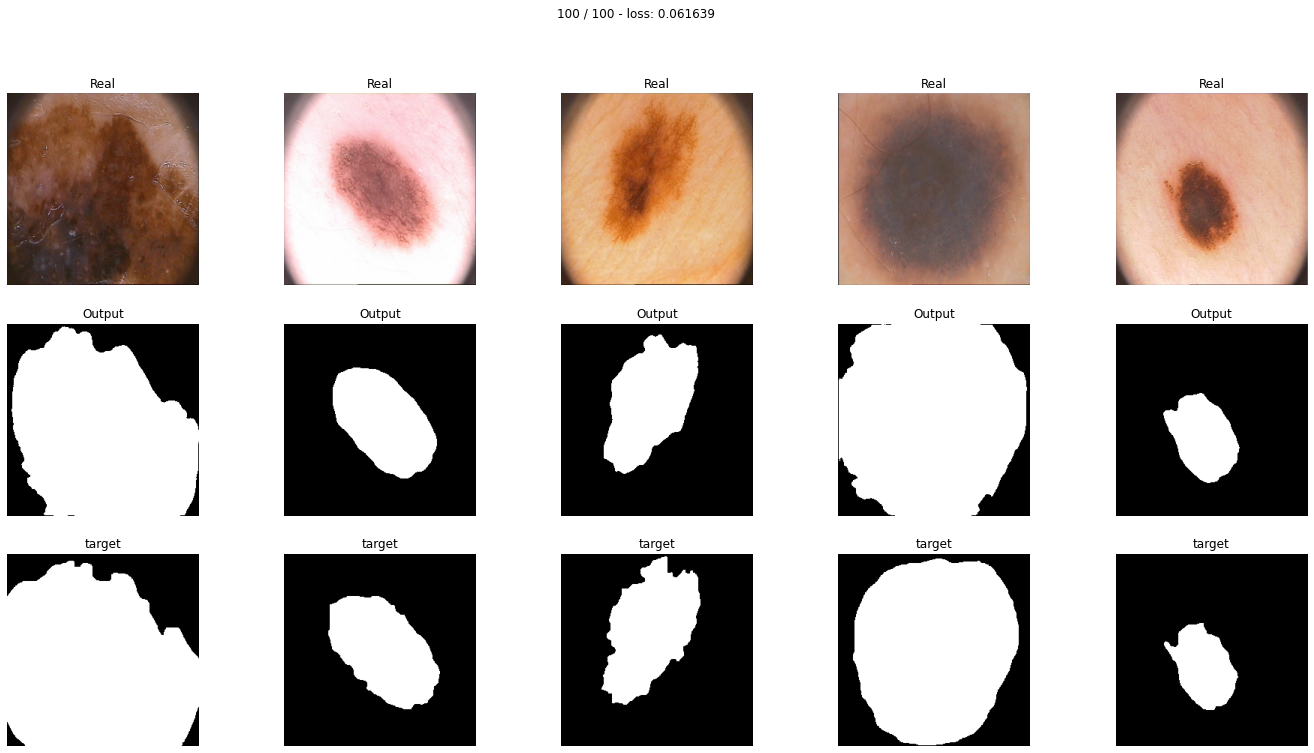

In [34]:
max_epochs = 100
optimizer = optim.Adam(unet2_model.parameters(), lr=0.0001)
shed = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5,  factor=0.5)
unet2_bce = train(unet2_model, optimizer, bce_loss, max_epochs, data_tr, data_val, shed, pictures=True)

In [35]:
score_model(unet2_model, iou_pytorch, data_val)

0.806000030040741

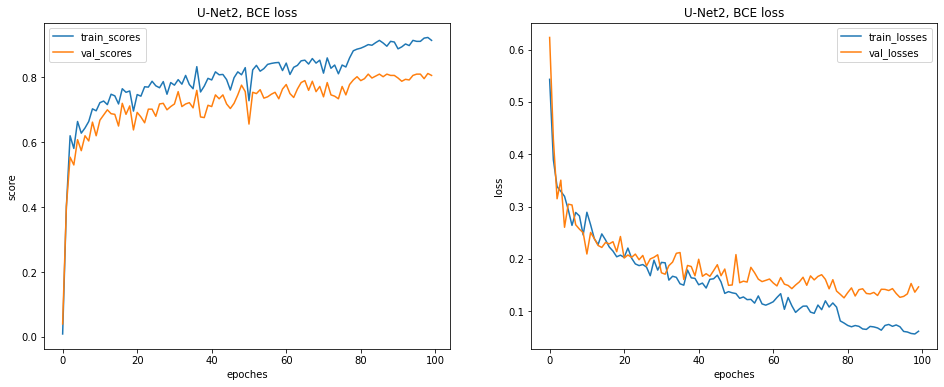

In [36]:
history_plot(unet2_bce, 'U-Net2, BCE loss')

In [38]:
# сохраняем модель и историю обучения для отчета
torch.save(unet2_model.state_dict(), "./unet2_bce.pth")
with open('unet2_bce.pkl', 'wb') as f:
    pickle.dump(unet2_bce, f)

Сделайте вывод какая из моделей лучше

Score у моделей фактически одинаковый, U-Net2 выглядит стабильнее, но сделать какие-то выводы о том, какая модель лучше нельзя. Позже проверим модели с другими лоссами.

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать достаточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключевой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

Для начала обучим U-Net и U-Net2, используя дополнительные функции потерь. Картинки сегментации печатать не будем, достаточно их уже было =)

U-Net, ф-я потерь dice_loss:

In [39]:
unet_model = UNet().to(device)

In [40]:
max_epochs = 100
optimizer = optim.Adam(unet_model.parameters(), lr=0.0001)
shed = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5,  factor=0.5)
unet_dice = train(unet_model, optimizer, dice_loss, max_epochs, data_tr, data_val, shed, pictures=False)

loss: 0.058154


In [41]:
score_model(unet_model, iou_pytorch, data_val)

0.8280000567436219

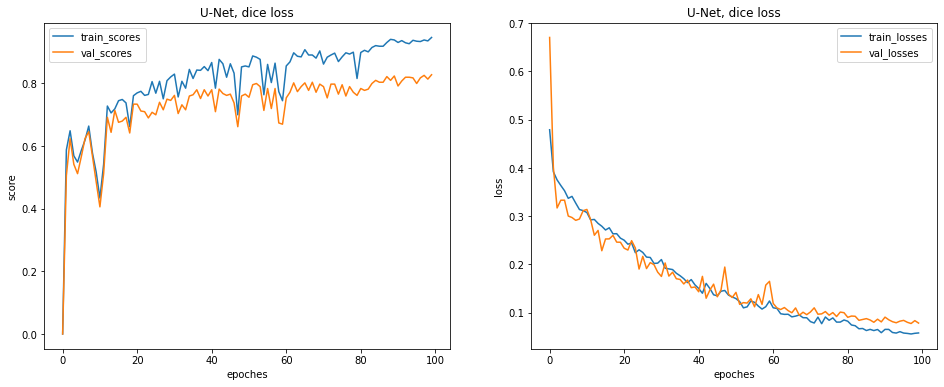

In [42]:
history_plot(unet_dice, 'U-Net, dice loss')

In [43]:
# сохраняем модель и историю обучения для отчета
torch.save(unet_model.state_dict(), "./unet_dice.pth")
with open('unet_dice.pkl', 'wb') as f:
    pickle.dump(unet_dice, f)

U-Net, ф-я потерь focal_loss:

In [44]:
unet_model = UNet().to(device)

In [45]:
max_epochs = 100
optimizer = optim.Adam(unet_model.parameters(), lr=0.0001)
shed = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5,  factor=0.5)
unet_focal = train(unet_model, optimizer, focal_loss, max_epochs, data_tr, data_val, shed, pictures=False)

loss: 0.115472


In [46]:
score_model(unet_model, iou_pytorch, data_val)

0.7980000257492066

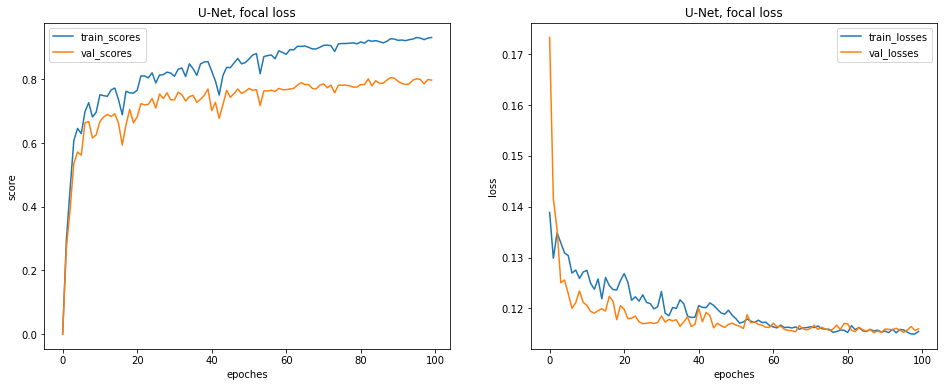

In [47]:
history_plot(unet_focal, 'U-Net, focal loss')

In [48]:
# сохраняем модель и историю обучения для отчета
torch.save(unet_model.state_dict(), "./unet_focal.pth")
with open('unet_focal.pkl', 'wb') as f:
    pickle.dump(unet_focal, f)

U-Net, ф-я потерь lovasz_loss:

In [24]:
unet_model = UNet().to(device)

In [25]:
max_epochs = 100
optimizer = optim.Adam(unet_model.parameters(), lr=0.0001)
shed = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5,  factor=0.5)
unet_lovasz = train(unet_model, optimizer, lovasz_loss, max_epochs, data_tr, data_val, shed, pictures=False)

loss: 0.115373


In [27]:
print(score_model(unet_model, iou_pytorch, data_val))

0.804000049829483


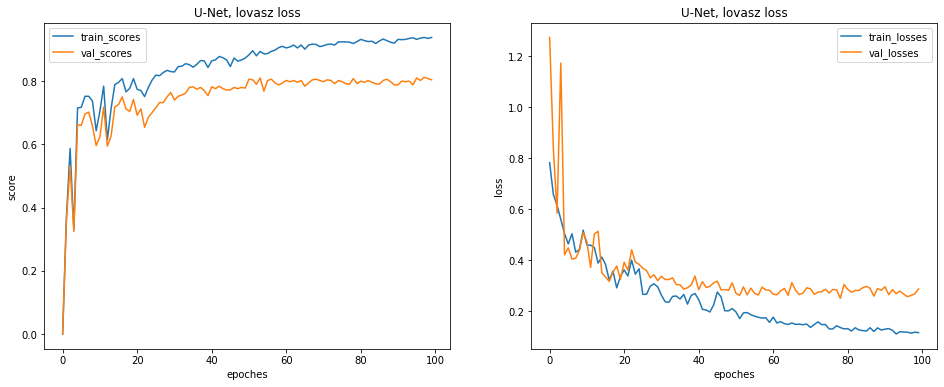

In [28]:
history_plot(unet_lovasz, 'U-Net, lovasz loss')

In [29]:
# сохраняем модель и историю обучения для отчета
torch.save(unet_model.state_dict(), "./unet_lovasz.pth")
with open('unet_lovasz.pkl', 'wb') as f:
    pickle.dump(unet_lovasz, f)

U-Net2, ф-я потерь dice_loss

In [49]:
unet2_model = UNet2().to(device)

In [50]:
max_epochs = 100
optimizer = optim.Adam(unet2_model.parameters(), lr=0.0001)
shed = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5,  factor=0.5)
unet2_dice = train(unet2_model, optimizer, dice_loss, max_epochs, data_tr, data_val, shed, pictures=False)

loss: 0.057830


In [51]:
score_model(unet2_model, iou_pytorch, data_val)

0.7940000355243683

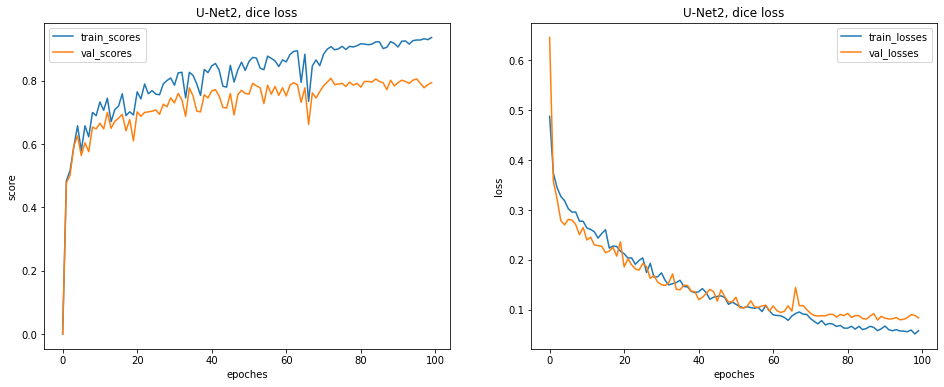

In [52]:
history_plot(unet2_dice, 'U-Net2, dice loss')

In [53]:
# сохраняем модель и историю обучения для отчета
torch.save(unet2_model.state_dict(), "./unet2_dice.pth")
with open('unet2_dice.pkl', 'wb') as f:
    pickle.dump(unet2_dice, f)

U-Net2, ф-я потерь focal_loss

In [30]:
unet2_model = UNet2().to(device)

In [31]:
max_epochs = 100
optimizer = optim.Adam(unet2_model.parameters(), lr=0.0001)
shed = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5,  factor=0.5)
unet2_focal = train(unet2_model, optimizer, focal_loss, max_epochs, data_tr, data_val, shed, pictures=False)

loss: 0.118587


In [32]:
score_model(unet2_model, iou_pytorch, data_val)

0.7600000143051148

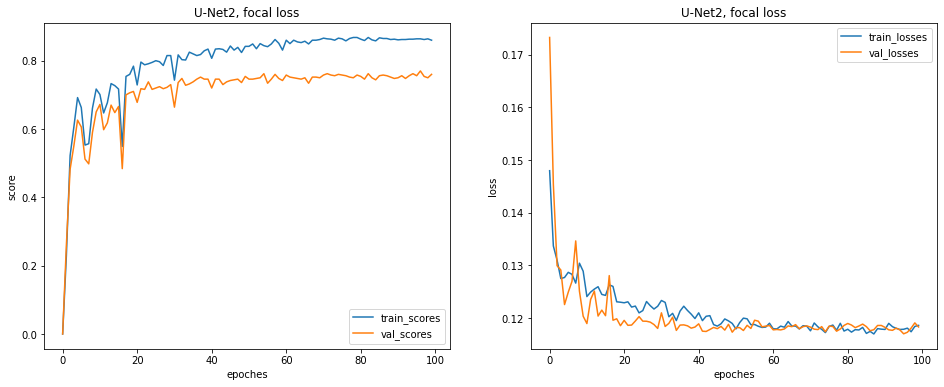

In [33]:
history_plot(unet2_focal, 'U-Net2, focal loss')

In [34]:
# сохраняем модель и историю обучения для отчета
torch.save(unet2_model.state_dict(), "./unet2_focal.pth")
with open('unet2_focal.pkl', 'wb') as f:
    pickle.dump(unet2_focal, f)

U-Net2, ф-я потерь lovasz_loss:

In [35]:
unet2_model = UNet().to(device)

In [36]:
max_epochs = 100
optimizer = optim.Adam(unet2_model.parameters(), lr=0.0001)
shed = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5,  factor=0.5)
unet2_lovasz = train(unet2_model, optimizer, lovasz_loss, max_epochs, data_tr, data_val, shed, pictures=False)

loss: 0.103892


In [37]:
score_model(unet2_model, iou_pytorch, data_val)

0.8000000298023224

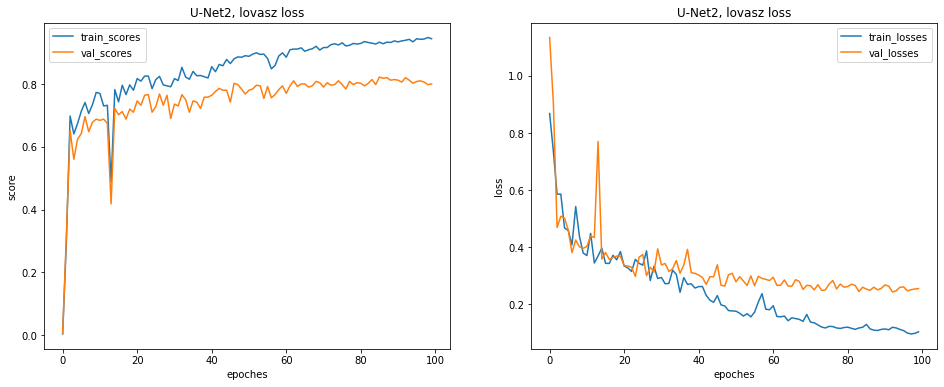

In [38]:
history_plot(unet2_lovasz, 'U-Net2, lovasz loss')

In [39]:
# сохраняем модель и историю обучения для отчета
torch.save(unet2_model.state_dict(), "./unet2_lovasz.pth")
with open('unet2_lovasz.pkl', 'wb') as f:
    pickle.dump(unet2_lovasz, f)

In [21]:
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

In [22]:
models_list = ['segnet', 'unet', 'unet2']
losses_list = ['bce', 'dice', 'focal', 'lovasz']

Загрузим ранее сохраненные истории обучения и выведем среднее время обучения одной эпохи.

In [27]:
history = {}

In [47]:
max_epochs = 100
print('Среднее время обучения одной эпохи, секунд:', end='\n\n')
for model in models_list:
    for loss in losses_list:
        name = model + '_' + loss
        path = name + '.pkl'
        with open (path, 'rb') as f:
            history[name] = pickle.load(f)
            time = sum(history[name]['times']) / max_epochs
            print(f'Модель {name} =', f'{time:.2f}')

Среднее время обучения одной эпохи, секунд:

Модель segnet_bce = 2.32
Модель segnet_dice = 2.26
Модель segnet_focal = 2.31
Модель segnet_lovasz = 2.87
Модель unet_bce = 2.62
Модель unet_dice = 2.61
Модель unet_focal = 2.64
Модель unet_lovasz = 2.62
Модель unet2_bce = 2.83
Модель unet2_dice = 2.82
Модель unet2_focal = 2.81
Модель unet2_lovasz = 2.61


SegNet учится немного быстрее на всех ф-х потерь, кроме lovasz.

Сравним между собой SegNet, U-Net и U-Net2 с различными функциями потерь на валидационной выборке.

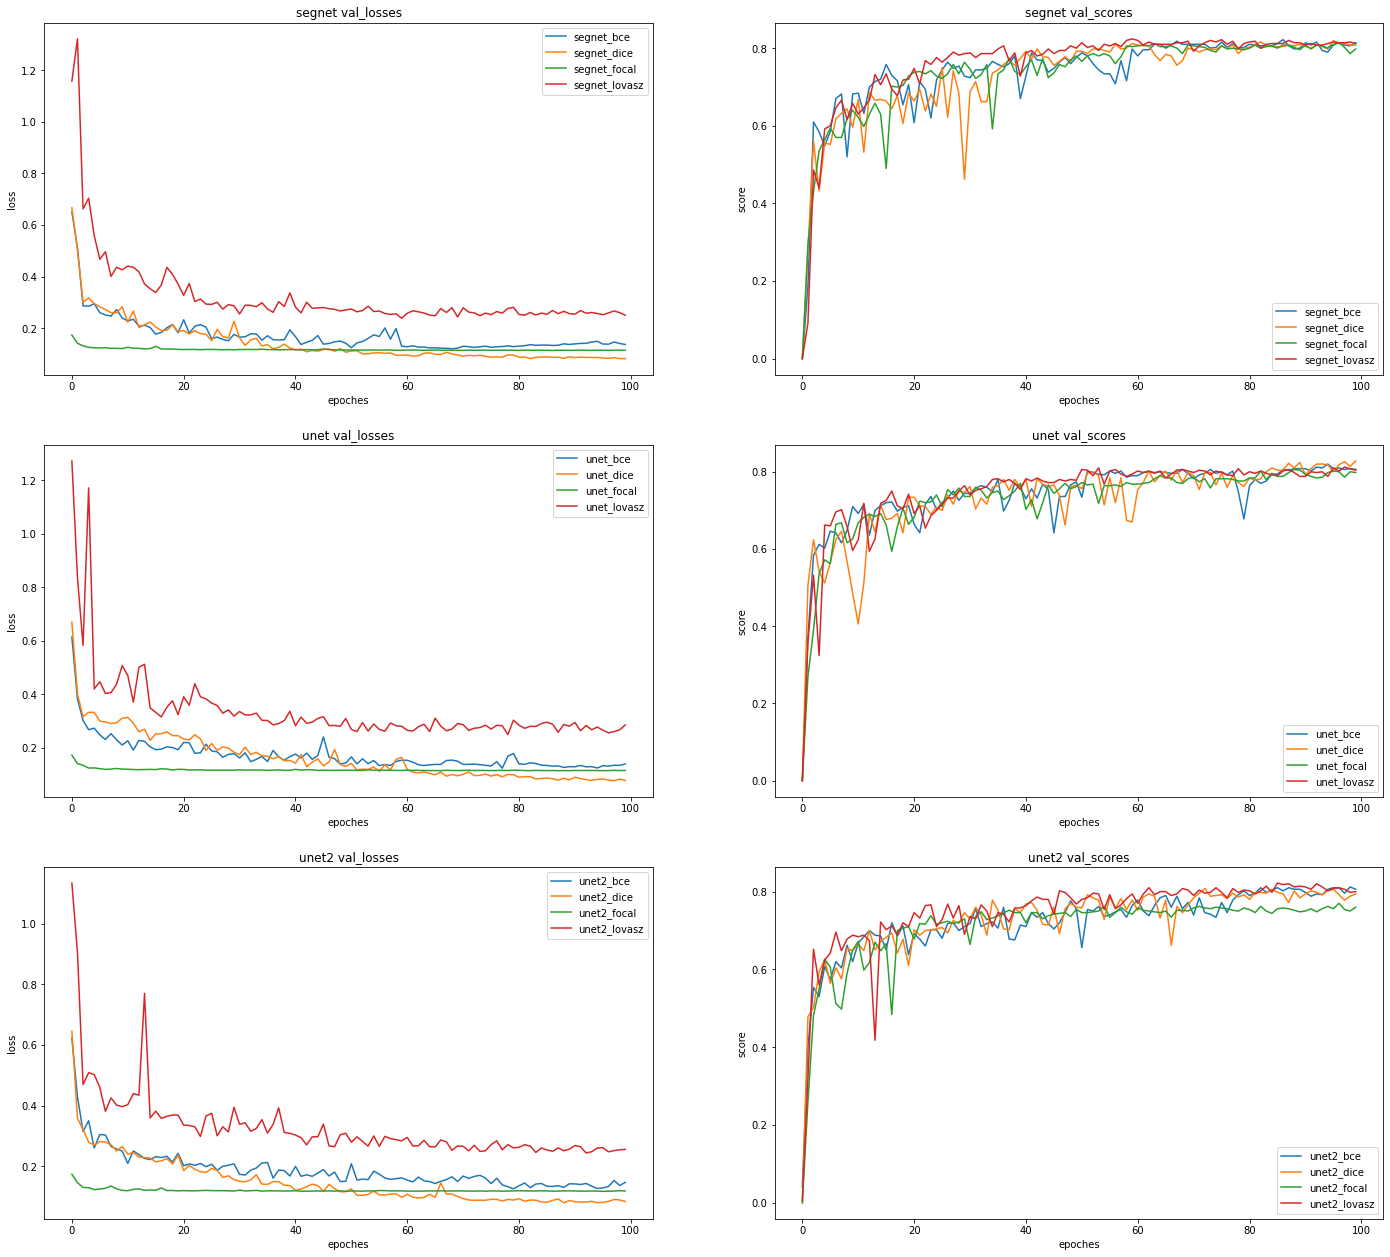

In [35]:
n = 1
plt.figure(figsize=(24, 22))
for model in models_list:
    for loss in losses_list:
        plt.subplot(3, 2, n)
        name = model+'_'+loss
        data = history[name]['val_losses']
        sns.lineplot(data=data, label=name).set(xlabel='epoches', ylabel='loss', title=model+' val_losses')
        plt.subplot(3, 2, n+1)
        data = history[name]['val_scores']
        sns.lineplot(data=data, label=name).set(xlabel='epoches', ylabel='score', title=model+' val_scores')
    n += 2

Обучение моделей с различными лоссами отличается. 

Lovasz сходится медленнее, но при этом показывает достойный скор, на бОльшем объеме данных вполне вероятно, что он показал бы лучший результат.

Поведение focal довольно странное, при нем лосс быстро падает до 0.15 и потом практически не меняется.

Графики dice и BCE похожи, dice менее стабилен на ранних эпохах с высоким learning rate и лучше сходится на поздних, когда lr низкий

По score все модели показывают практически иденчиный результат, разве что U-Net2 + focal чуть хуже, а dice чуть лучше.

Построим графики всех трех моделей с dice loss.

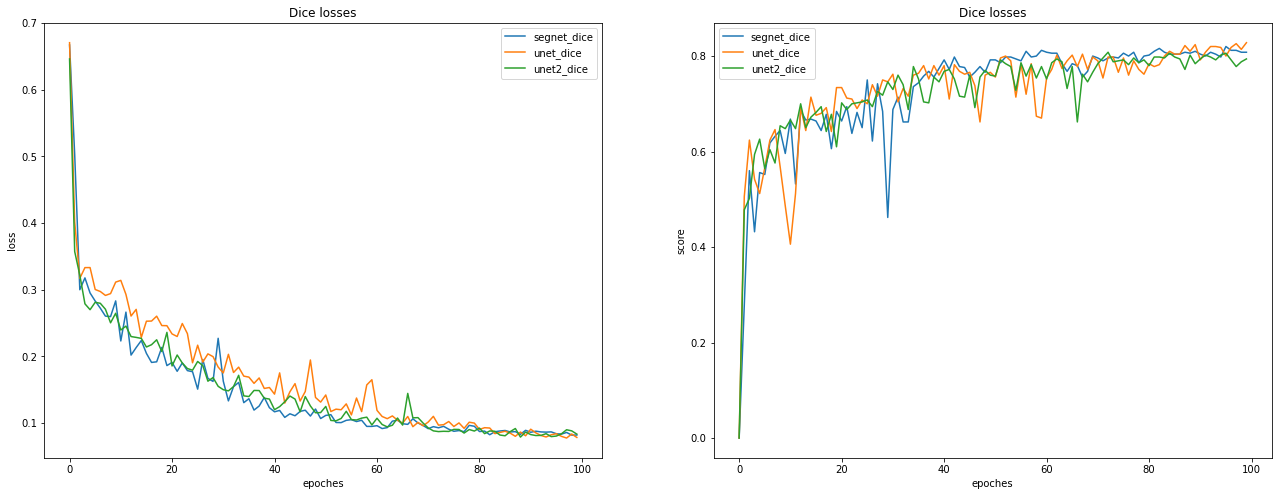

In [48]:
plt.figure(figsize=(22, 8))
for model in models_list:
    plt.subplot(1, 2, 1)
    name = model+'_dice'
    data = history[name]['val_losses']
    sns.lineplot(data=data, label=name).set(xlabel='epoches', ylabel='loss', title='Dice losses')
    plt.subplot(1, 2, 2)
    data = history[name]['val_scores']
    sns.lineplot(data=data, label=name).set(xlabel='epoches', ylabel='score', title='Dice losses')

На валидации U-Net + dice_loss показывает лучший результат, но различия оч незначительные, утверждать что U-Net является лучшей моделью на основание этих графиков нельзя. Проверим все три модели с dice_loss на тестовой выборке.

Проведем такой эксперимент - обучим эти модели на train + valid выборках и сделаем финальную проверку на test выборке.

In [23]:
data_train_val = DataLoader(list(zip(np.rollaxis(X[np.append(tr, val)], 3, 1), Y[np.append(tr, val), np.newaxis])), 
                     batch_size=batch_size, shuffle=True)

In [25]:
segnet_dice = SegNet().to(device)

In [26]:
optimizer = optim.Adam(segnet_dice.parameters(), lr=0.0001)
shed = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5,  factor=0.5)
segnet_dice_final = train(segnet_dice, optimizer, dice_loss, max_epochs, data_train_val, data_ts, shed, pictures=False)

loss: 0.032659


In [28]:
segnet_dice_test_score = score_model(segnet_dice, iou_pytorch, data_ts)

In [30]:
with open('segnet_dice_final.pkl', 'wb') as f:
    pickle.dump(segnet_dice_final, f)

In [31]:
unet_dice = UNet().to(device)

In [32]:
optimizer = optim.Adam(unet_dice.parameters(), lr=0.0001)
shed = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5,  factor=0.5)
unet_dice_final = train(unet_dice, optimizer, dice_loss, max_epochs, data_train_val, data_ts, shed, pictures=False)

loss: 0.034838


In [33]:
unet_dice_test_score = score_model(unet_dice, iou_pytorch, data_ts)

In [35]:
with open('unet_dice_final.pkl', 'wb') as f:
    pickle.dump(unet_dice_final, f)

In [36]:
unet2_dice = UNet2().to(device)

In [37]:
optimizer = optim.Adam(unet2_dice.parameters(), lr=0.0001)
shed = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5,  factor=0.5)
unet2_dice_final = train(unet2_dice, optimizer, dice_loss, max_epochs, data_train_val, data_ts, shed, pictures=False)

loss: 0.045848


In [38]:
unet2_dice_test_score = score_model(unet2_dice, iou_pytorch, data_ts)

In [40]:
with open('unet2_dice_final.pkl', 'wb') as f:
    pickle.dump(unet2_dice_final, f)

In [41]:
print('Test scores:')
print('SegNet + dice test score:', f'{segnet_dice_test_score:.2f}')
print('U-Net + dice test score:', f'{unet_dice_test_score:.2f}')
print('U-Net2 + dice test score:', f'{unet2_dice_test_score:.2f}')

Test scores:
SegNet + dice test score: 0.83
U-Net + dice test score: 0.85
U-Net2 + dice test score: 0.81


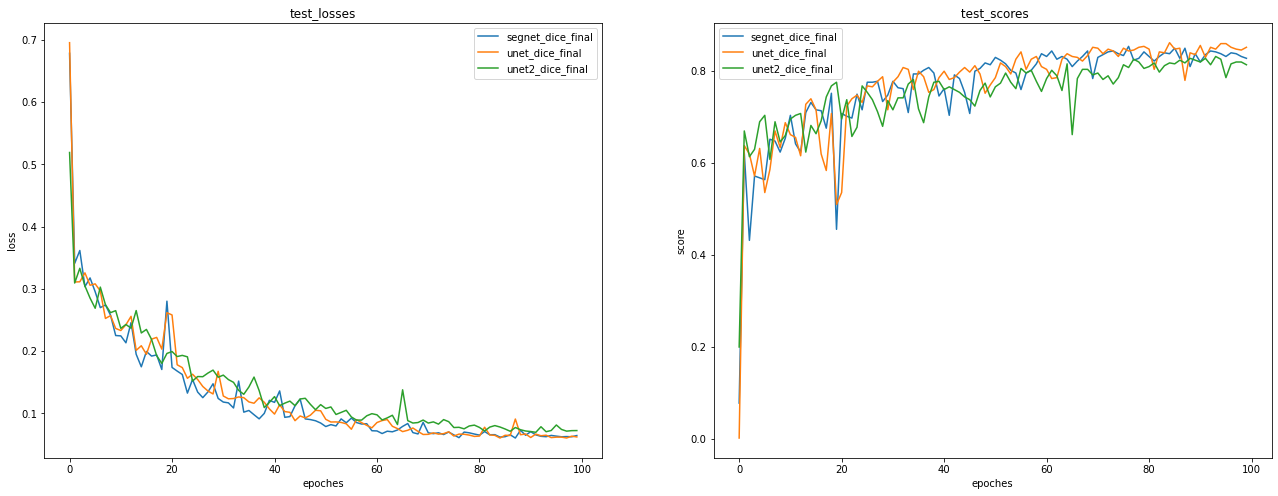

In [46]:
history['unet_dice_final'] = unet_dice_final
history['segnet_dice_final'] = segnet_dice_final
history['unet2_dice_final'] = unet2_dice_final

plt.figure(figsize=(22, 8))
for model in models_list:
    plt.subplot(1, 2, 1)
    name = model+'_dice_final'
    data = history[name]['val_losses']
    sns.lineplot(data=data, label=name).set(xlabel='epoches', ylabel='loss', title='test_losses')
    plt.subplot(1, 2, 2)
    data = history[name]['val_scores']
    sns.lineplot(data=data, label=name).set(xlabel='epoches', ylabel='score', title=' test_scores')

Увеличение размера обучающей выборки ожидаемо подняло score у всех моделей, отрыв U-Net+dice стал чуть более заметным. С большой натяжкой можно предположить, что данная модель лучше остальных. Но SegNet+dice так же отличный кандидат в случае, когда нам важна производительность, благодаря тому, что это самая быстро обучаемая из всех моделей.

Для дальнейшего увеличения score можно было бы аугментировать данные, предполагаю что это могло бы еще добавить качества моделям. Так же можно почистить датасет, удалив объекты с очень плохой ручной сегментацией.

Но тк это задание все же не про достижение макс скора, а про сравнение моделей, решил оставить данные такими, как они были.